In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import xgboost as xgb

In [3]:
# Define file paths
data_path = '/content/drive/MyDrive/Colab Notebooks/DSP Project/'
data_1 = data_path + 'Merged_Sorted_Data_Device_Daily.xlsx'

# Load the Excel files
data = pd.read_excel(data_1)

# Ensure the date column is parsed as a datetime object
data['Date'] = pd.to_datetime(data['Date'])

# Sort by the Date column
data = data.sort_values(by='Date')

data

/usr/local/lib/python3.10/dist-packages/google/colab/_dataframe_summarizer.py:88: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  cast_date_col = pd.to_datetime(column, errors="coerce")


,Robot Address,Date,Milk Speed Avg.,Milk Duration,Time Milking,Milk Exp.,Milk Tot.,No. of Feed Visits
0,101,2010-10-15,NaN,NaN,00:00,NaN,NaN,701.0
1,103,2010-10-15,NaN,NaN,00:01,NaN,NaN,121.0
2,12,2014-04-08,NaN,NaN,NaN,NaN,NaN,2.0
3,103,2014-04-08,NaN,0:00,00:01,NaN,0.0,1.0
4,102,2014-04-08,NaN,0:00,00:00,NaN,0.0,1.0
...,...,...,...,...,...,...,...,...
28723,SUM,NaT,NaN,NaN,NaN,NaN,2498882.9,NaN
28724,AVG,NaT,NaN,NaN,30:08,NaN,1161.1,NaN
28725,SUM,NaT,NaN,NaN,NaN,NaN,3799173.6,NaN
28726,AVG,NaT,NaN,NaN,10:10,NaN,973.7,NaN


In [4]:
# Display a concise summary of the dataframe
print(data.info())

# Generate descriptive statistics
print(data.describe())

# Check for missing values
print(data.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
Index: 28728 entries, 0 to 28727
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Robot Address       28728 non-null  object        
 1   Date                28718 non-null  datetime64[ns]
 2   Milk Speed Avg.     11169 non-null  float64       
 3   Milk Duration       11169 non-null  object        
 4   Time Milking        11179 non-null  object        
 5   Milk Exp.           11169 non-null  float64       
 6   Milk Tot.           11182 non-null  float64       
 7   No. of Feed Visits  28718 non-null  float64       
dtypes: datetime64[ns](1), float64(4), object(3)
memory usage: 3.0+ MB
None
                                Date  Milk Speed Avg.     Milk Exp.  \
count                          28718     11169.000000  11169.000000   
mean   2019-07-12 07:43:04.107528192         2.956084   1101.669800   
min              2010-10-15 00:00:00         0.0

In [5]:
# Define a function to convert time in MM:SS format to seconds
def time_to_seconds(time_str):
    try:
        # Split time by ':' and convert to minutes and seconds
        m, s = map(int, time_str.split(':'))
        return m * 60 + s
    except:
        return None  # Return None if the time format is invalid or it's NaN

# List of time-related columns to process
time_columns = ['Milk Duration', 'Time Milking']

# Loop over each time-related column to convert and leave NaNs intact
for column in time_columns:
    # Convert the time strings to seconds
    data[column] = data[column].apply(time_to_seconds)

data

,Robot Address,Date,Milk Speed Avg.,Milk Duration,Time Milking,Milk Exp.,Milk Tot.,No. of Feed Visits
0,101,2010-10-15,NaN,NaN,0.0,NaN,NaN,701.0
1,103,2010-10-15,NaN,NaN,1.0,NaN,NaN,121.0
2,12,2014-04-08,NaN,NaN,NaN,NaN,NaN,2.0
3,103,2014-04-08,NaN,0.0,1.0,NaN,0.0,1.0
4,102,2014-04-08,NaN,0.0,0.0,NaN,0.0,1.0
...,...,...,...,...,...,...,...,...
28723,SUM,NaT,NaN,NaN,NaN,NaN,2498882.9,NaN
28724,AVG,NaT,NaN,NaN,1808.0,NaN,1161.1,NaN
28725,SUM,NaT,NaN,NaN,NaN,NaN,3799173.6,NaN
28726,AVG,NaT,NaN,NaN,610.0,NaN,973.7,NaN


In [6]:
# Convert 'Robot Address' to numeric, coercing any errors
data['Robot Address'] = pd.to_numeric(data['Robot Address'], errors='coerce')

In [7]:
# Calculate the percentage of missing values in each column
missing_percentage = data.isnull().mean() * 100

# Display columns with more than 50% missing values
print(missing_percentage[missing_percentage > 50])

Milk Speed Avg.    61.121554
Milk Duration      61.121554
Time Milking       61.086745
Milk Exp.          61.121554
Milk Tot.          61.076302
dtype: float64


In [8]:
# # List of columns with more than 60% null values
# columns_to_drop_nulls = ['Milk Speed Avg.', 'Milk Duration', 'Time Milking', 'Milk Exp.', 'Milk Tot.']

# # Drop rows where any of these columns have null values
# df_cleaned = data.dropna(subset=columns_to_drop_nulls)

In [9]:
# List of columns to impute
columns_to_impute = ['Milk Speed Avg.', 'Milk Duration', 'Time Milking', 'Milk Exp.', 'Milk Tot.']

# Impute missing values with the median for each column
for column in columns_to_impute:
    # Convert the column to numeric, forcing non-numeric values to NaN
    data[column] = pd.to_numeric(data[column], errors='coerce')

    # Calculate median and fill NaN values
    median_value = data[column].median()
    data.loc[:, column] = data[column].fillna(median_value)

In [10]:
# Remove rows where 'Date' or 'No. of Feed Visits' are NaN
data = data.dropna(subset=['Date', 'No. of Feed Visits'])

In [11]:
# Drop the 'Date' column from the DataFrame
data = data.drop('Date', axis=1)

print(data.isnull().sum())

data

Robot Address         0
Milk Speed Avg.       0
Milk Duration         0
Time Milking          0
Milk Exp.             0
Milk Tot.             0
No. of Feed Visits    0
dtype: int64


,Robot Address,Milk Speed Avg.,Milk Duration,Time Milking,Milk Exp.,Milk Tot.,No. of Feed Visits
0,101.0,3.0,227.0,0.0,1090.0,1084.6,701.0
1,103.0,3.0,227.0,1.0,1090.0,1084.6,121.0
2,12.0,3.0,227.0,651.0,1090.0,1084.6,2.0
3,103.0,3.0,0.0,1.0,1090.0,0.0,1.0
4,102.0,3.0,0.0,0.0,1090.0,0.0,1.0
...,...,...,...,...,...,...,...
28712,102.0,2.9,263.0,486.0,766.0,782.9,95.0
28713,32.0,3.0,227.0,651.0,1090.0,1084.6,546.0
28714,31.0,3.0,227.0,651.0,1090.0,1084.6,490.0
28715,33.0,3.0,227.0,651.0,1090.0,1084.6,365.0


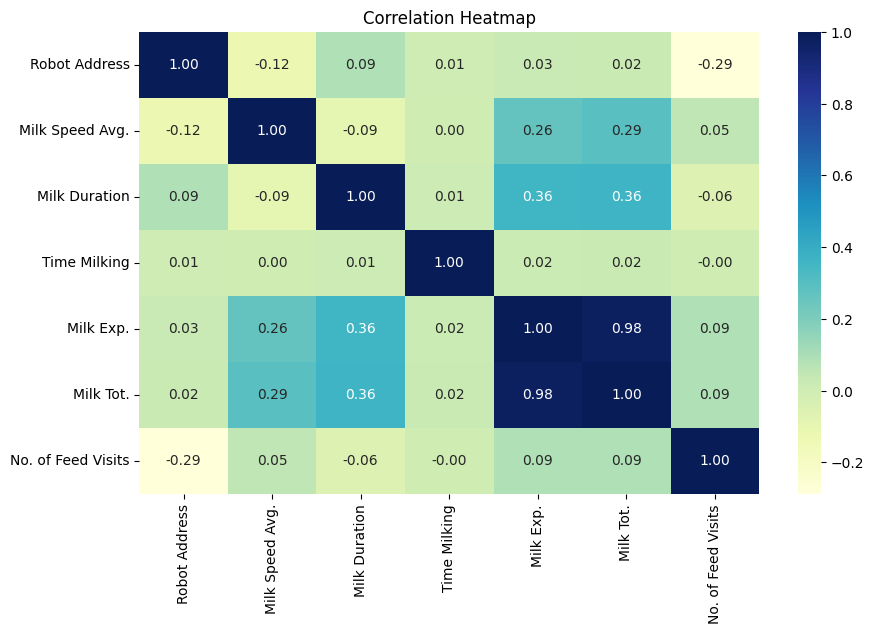

In [12]:
# Select only numeric columns
numeric_data = data.select_dtypes(include='number')

# Calculate the correlation matrix
correlation_matrix = numeric_data.corr()

# Plot the heatmap for correlations
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="YlGnBu", fmt='.2f')  # 'annot=True' to show correlation values
plt.title('Correlation Heatmap')
plt.show()

In [13]:
# X is the feature matrix
# y is the target variable
X = data.drop(['Milk Exp.', 'Milk Tot.'], axis=1)  # Drop target and any other non-relevant columns
y = data['Milk Exp.']

# First, split into train (70%) and temp (30%) data
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)

# Next, split the temp data into validation (20% of total) and test (10% of total)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.33, random_state=42)

print(f"Train size: {len(X_train)}, Validation size: {len(X_val)}, Test size: {len(X_test)}")

Train size: 20102, Validation size: 5772, Test size: 2844


In [14]:
# Initialize the models
models = {
    'Linear Regression': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'Random Forest': RandomForestRegressor(random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42),
    'XGBoost': xgb.XGBRegressor(random_state=42)
}

In [15]:
# Initialize an empty dictionary to store results
results = {}

# Train and evaluate each model
for name, model in models.items():
    print(f"\nTraining and validating {name}...")

    # Train the model
    model.fit(X_train, y_train)

    # Predict on the validation set
    y_val_pred = model.predict(X_val)

    # Calculate metrics
    mse_val = mean_squared_error(y_val, y_val_pred)
    r2_val = r2_score(y_val, y_val_pred)

    # Print validation performance
    print(f"Validation MSE: {mse_val}")
    print(f"Validation R-squared: {r2_val}")

    # Store results for comparison
    results[name] = {
        'Validation MSE': mse_val,
        'Validation R2': r2_val
    }


Training and validating Linear Regression...
Validation MSE: 41690.775209592124
Validation R-squared: 0.2427376287752182

Training and validating Decision Tree...
Validation MSE: 10156.456427581428
Validation R-squared: 0.8155202862281645

Training and validating Random Forest...
Validation MSE: 5403.168783130788
Validation R-squared: 0.90185799174346

Training and validating Gradient Boosting...
Validation MSE: 5207.270954572035
Validation R-squared: 0.9054162382242801

Training and validating XGBoost...
Validation MSE: 5638.057213058477
Validation R-squared: 0.897591528274597


In [16]:
# Display the validation results for each model
for model_name, metrics in results.items():
    print(f"\n{model_name}:")
    print(f"  Validation MSE: {metrics['Validation MSE']}")
    print(f"  Validation R2: {metrics['Validation R2']}")


Linear Regression:
  Validation MSE: 41690.775209592124
  Validation R2: 0.2427376287752182

Decision Tree:
  Validation MSE: 10156.456427581428
  Validation R2: 0.8155202862281645

Random Forest:
  Validation MSE: 5403.168783130788
  Validation R2: 0.90185799174346

Gradient Boosting:
  Validation MSE: 5207.270954572035
  Validation R2: 0.9054162382242801

XGBoost:
  Validation MSE: 5638.057213058477
  Validation R2: 0.897591528274597


In [17]:
# Choose the best model based on validation performance
best_model = models['Gradient Boosting']

# Predict on the test set
y_test_pred = best_model.predict(X_test)

# Calculate performance metrics on the test set
mse_test = mean_squared_error(y_test, y_test_pred)
r2_test = r2_score(y_test, y_test_pred)

# Print test set performance
print("\nTest Set Performance of Best Model (Gradient Boosting):")
print(f"Test MSE: {mse_test}")
print(f"Test R-squared: {r2_test}")


Test Set Performance of Best Model (Gradient Boosting):
Test MSE: 5237.469143000089
Test R-squared: 0.9090613209338014


In [18]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV

# Define the parameter grid for Gradient Boosting
param_grid = {
    'n_estimators': [100, 200, 300],   # Number of boosting stages
    'max_depth': [3, 5, 10],           # Maximum depth of individual trees
    'min_samples_split': [2, 5, 10],   # Minimum number of samples required to split an internal node
    'learning_rate': [0.01, 0.1, 0.05],  # Learning rate shrinks the contribution of each tree
    'subsample': [0.8, 1.0]            # Fraction of samples to be used for fitting each base learner
}

# Initialize the Gradient Boosting model
gb_model = GradientBoostingRegressor(random_state=42)

# Initialize the grid search
grid_search = GridSearchCV(estimator=gb_model, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)

# Fit the grid search
grid_search.fit(X_train, y_train)

# Best parameters and best score
print("Best Parameters:", grid_search.best_params_)
print("Best Score (MSE):", -grid_search.best_score_)  # Negate to convert to positive MSE

# Train the best model on the full training set
best_gb_model = grid_search.best_estimator_

Best Parameters: {'learning_rate': 0.05, 'max_depth': 5, 'min_samples_split': 10, 'n_estimators': 200, 'subsample': 0.8}
Best Score (MSE): 4954.328416825746


In [19]:
# Predict on the validation set
y_val_pred = best_gb_model.predict(X_val)

# Calculate MSE and R-squared on the validation set
mse_val = mean_squared_error(y_val, y_val_pred)
r2_val = r2_score(y_val, y_val_pred)

print(f"Validation MSE: {mse_val}")
print(f"Validation R-squared: {r2_val}")

# Predict on the test set
y_test_pred = best_gb_model.predict(X_test)

# Calculate MSE and R-squared on the test set
mse_test = mean_squared_error(y_test, y_test_pred)
r2_test = r2_score(y_test, y_test_pred)

print(f"Test MSE: {mse_test}")
print(f"Test R-squared: {r2_test}")

Validation MSE: 4863.53877950709
Validation R-squared: 0.9116597163233883
Test MSE: 4807.997174249158
Test R-squared: 0.9165182839187513
